# Trying to make an animation of Lagrangian particles

## Part of a project to quantify transports across the Greenland-Scotland section by source and destination

- Lagrangian particle tracking in VIKING20X model

- animation with matplotlib

## Technical preamble

In [1]:
%matplotlib inline

In [2]:


from pathlib import Path
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
import cmocean as co
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

np.warnings.filterwarnings('ignore')


## Parameters

In [3]:
# release time

trelease = np.datetime64('2015-12-16T12:00')

# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# select section FS, IF, or GI

section = 'FS'

if section == 'FS':
    
    # Faroe-Shetland
    path_data_tracks = Path('data/processed/tracks/FaroeShetland/') 
    filename = 'tracks_parcels_FS_forwards_201512.nc'
    filenameb = 'tracks_parcels_FS_backwards_201512.nc'
    path_animation = Path('reports/animations/')
    filename_animation = '005_afox_parcels_transports_animation_FS_201512.mp4'

    #velocity conversions on FS channel (61N)

    lat2metres = 60.0*1852.0
    lon2metres = 60.0*1852.0*np.cos(np.radians(61.0))

    sealandratio = 5591.0/20000.0
    sectionAreaEW = 5.7 * 1500.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
    sectionAreaNS = 1.87 * 1500.0 * sealandratio * lat2metres

    
elif section == 'IF':
    
    # Iceland-Faroe
    path_data_tracks = Path('data/processed/tracks/IcelandFaroe/') 
    filename = 'tracks_parcels_IFR_forwards_201512.nc'
    filenameb = 'tracks_parcels_IFR_backwards_201512.nc'
    path_animation = Path('reports/animations/')
    filename_animation = '005_afox_parcels_transports_animation_IF_201512.mp4'

    #velocity conversions on IFR (63.5N)

    lat2metres = 60.0*1852.0
    lon2metres = 60.0*1852.0*np.cos(np.radians(63.5))

    sealandratio = 9308.0/20000.0
    sectionAreaEW = 7.0 * 700.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
    sectionAreaNS = 2.8 * 700.0 * sealandratio * lat2metres
    
else:

    # Greenland-Iceland
    path_data_tracks = Path('data/processed/tracks/GreenlandIceland/') 
    filename = 'tracks_parcels_GI_forwards_201512.nc'
    filenameb = 'tracks_parcels_GI_backwards_201512.nc'
    path_animation = Path('reports/animations/')
    filename_animation = '005_afox_parcels_transports_animation_GI_201512.mp4'

    #velocity conversions on GI (67.3N)
    lat2metres = 60.0*1852.0
    lon2metres = 60.0*1852.0*np.cos(np.radians(67.3))

    sealandratio = 2420.0/10000.0
    sectionAreaEW = 5.73 * 1500.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
    sectionAreaNS = 2.94 * 1500.0 * sealandratio * lat2metres

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"


## Helper functions

In [4]:
def apply_through_area(ds, min_lon, max_lon, min_lat, max_lat, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  (
                    (ds.lon > min_lon) * 
                    (ds.lon < max_lon) *
                    (ds.lat > min_lat) * 
                    (ds.lat < max_lat) *
                    (ds.time > min_time) *
                    (ds.time < max_time)
                    )
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [5]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  ((((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                     > 0.0) *
                    (ds.time > min_time) *
                    (ds.time < max_time))
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [6]:
def mask_tracks_by_source_sink(ds_full,trelease):
    # comes through Rockall Trough and W Scotland shelf
    ds_area = apply_through_area(ds_full,-13.5,-6.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_RT_WSS')    
    # comes northward west of Rockall Bank
    ds_area = apply_through_area(ds_area,-60,-13.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_WRB')  
    # comes clockwise round Iceland
    ds_area = apply_through_area(ds_area,-22,-20,65,70,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_WIceland')  
    # comes from NW
    ds_area = apply_through_area(ds_area,-20,-6,68.5,70,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_GreenSea')  
    # goes northeastward towards Arctic - all particles doing this pass north of Faroe
    ds_area = apply_through_area(ds_area,-6.5,-5.5,62.3,64.5,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_NFaroes')    
    # goes west south of Iceland in SPG
    ds_area = apply_through_area(ds_area,-23,-22,62.,64.,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_SIceland')  
    # goes to arctic
    ds_area = apply_left_of_line(ds_area,0,7,65,62,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_NorwSea')
    # goes to north sea
    ds_area = apply_left_of_line(ds_area,5.1,-1.23,62.3,60.3,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_NSea')
    return ds_area

In [7]:
def transports():
    transport = (sectionAreaEW*dsb.isel(obs=0).vvel*lat2metres +
                            sectionAreaNS*dsb.isel(obs=0).uvel*lon2metres)/nParticles
    speed = np.sqrt((dsb.isel(obs=0).vvel*lat2metres)**2 + (dsb.isel(obs=0).uvel*lon2metres)**2)
    return transport,speed

## Load data

### Forward tracks then backward tracks

In [8]:
ds = xr.open_dataset(project_path / path_data_tracks / filename)
ds.temp.attrs['standard_name'] = 'temperature'
ds.temp.attrs['units'] = 'degree_C'
dsb = xr.open_dataset(project_path / path_data_tracks / filenameb)
dsb.temp.attrs['standard_name'] = 'temperature'
dsb.temp.attrs['units'] = 'degree_C'

ds_full = xr.concat([dsb,ds],dim='obs')

display(ds_full)


<xarray.Dataset>
Dimensions:     (obs: 1462, traj: 2000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 3.0 3.0 3.0 3.0 3.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2015-12-16T12:00:00 ... NaT
    lat         (traj, obs) float64 61.17 61.18 61.19 61.21 ... nan nan nan nan
    lon         (traj, obs) float64 -3.858 -3.807 -3.755 -3.718 ... nan nan nan
    z           (traj, obs) float64 551.4 555.8 560.1 563.9 ... nan nan nan nan
    temp        (traj, obs) float32 1.742226 1.7405465 1.7274325 ... nan nan nan
    uvel        (traj, obs) float32 -7.0260165e-07 -5.840501e-07 ... nan nan
    vvel        (traj, obs) float32 -7.4971354e-08 -1.2900848e-07 ... nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.2
    parcels_mesh:           spherical

### Load model mesh mask

In [9]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

## Calculate some basic parameters from data for later

In [10]:
nParticles = ds.sizes['traj']
nobsb = dsb.sizes['obs']

# calculate initial transports

particle_transport,speed0 = transports()
sizes = np.abs(particle_transport)/400.0


### Find subsets of trajectories passing through different areas, either upstream or downstream

This just tests whether particles were ever in an area, much easier than testing line crossings.

In [11]:
ds_area = mask_tracks_by_source_sink(ds_full,trelease)

### Animate trajectories

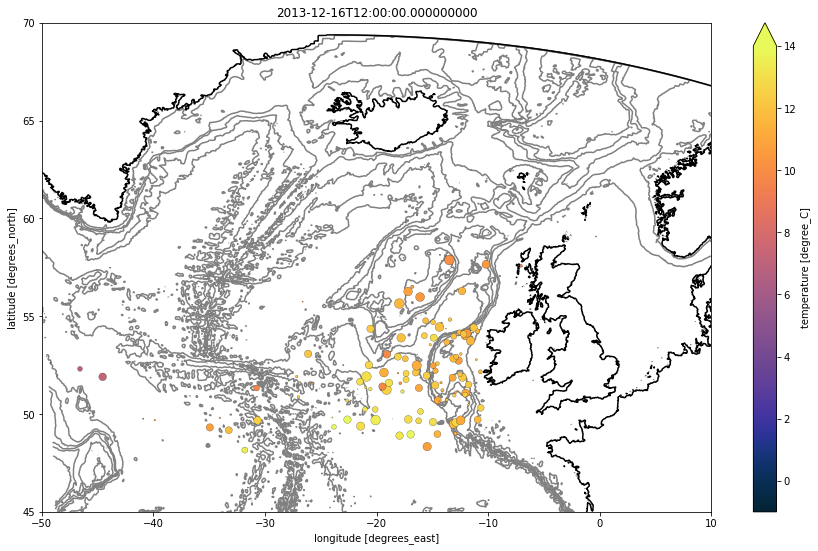

In [12]:
fig,ax = plt.subplots(figsize = (15,9))

# subset to plot

ds_anim = (ds_area.where(ds_area.isel(obs=-1).F_NFaroes == False)
                 .where(ds_area.isel(obs=-1).T_NorwSea)
                 .where(ds_area.isel(obs=-1).F_RT_WSS))

# plot depth contours and land boundary from model bathymetry background

depth.isel(y=slice(1700, 2499), x=slice(1000, 2404)).plot.contour(
    x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500],zorder = 1
);
depth.isel(y=slice(1700, 2499), x=slice(1000, 2404)).plot.contour(
    x="nav_lon", y="nav_lat", colors = 'k', levels = [1]
);
plt.ylim(45,70)
plt.xlim(-50,10)

scat = ds_anim.isel(obs=nobsb-1).plot.scatter('lon','lat',hue='temp',
                                     ax=ax,s=sizes,linewidth = 0.2,edgecolor = 'k',
                                     cmap = co.cm.thermal,vmin = -1.0, vmax = 14,zorder=10)
title = ax.set_title(dsb.isel(obs=-1).time.min(skipna = True).data)


def animate(i):
    if i < nobsb:
        scat.set_offsets(np.c_[ds_anim.isel(obs=nobsb-1-i).lon.data,
                               ds_anim.isel(obs=nobsb-1-i).lat.data])
        scat.set_array(ds_anim.isel(obs=nobsb-1-i).temp.data)
        title = ax.set_title(ds_anim.isel(obs=nobsb-1-i).time.min(skipna = True).data)
    else:
        scat.set_offsets(np.c_[ds_anim.isel(obs=i).lon.data,
                               ds_anim.isel(obs=i).lat.data])
        scat.set_array(ds_anim.isel(obs=i).temp.data)
        title = ax.set_title(ds_anim.isel(obs=i).time.min(skipna = True).data)
  
    return scat,title

anim = FuncAnimation(
    fig, animate,frames = ds_full.sizes['obs'],interval = 10,blit = True)

#### inline animation

In [13]:
HTML(anim.to_html5_video())

In [16]:
# to save to a file
anim.save(project_path / path_animation / filename_animation)